In [1]:
import os
import pickle
import igraph
import geoplot
import seaborn as sns
from collections import Counter
import numpy as np
import itertools
import pandas as pd
import geopandas as gpd
import mapclassify as mc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import contextily as ctx
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import matplotlib.colors as colors
import matplotlib.ticker as mtick
from collections import defaultdict
import cartopy
import sys
from mpl_toolkits.basemap import Basemap

from statsmodels.nonparametric.kernel_density import *

import GeoDataProcessing.dispatchAnalysis as DA

In [125]:
def loadVehicleRelocations(vehicleRecord, nodes_shp):
    outputDict = {'dashed': [], 'line': [], 'emergency': [], 'marker':[], 'specialMarker':[]}
    for i in range(2, len(vehicleRecord) - 1):
        if vehicleRecord[i][2] is None:
            outputDict['marker'].append((vehicleRecord[i][0], vehicleRecord[i][1]))
        else:
            if vehicleRecord[i+1][1] == vehicleRecord[i][2]:
                if vehicleRecord[i][3] == 'None':
                    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                    j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][2]][['lon', 'lat']].values[0]
                    outputDict['line'].append((vehicleRecord[i][0], i_coords, j_coords))
                else:
                    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                    j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][2]][['lon', 'lat']].values[0]
                    outputDict['emergency'].append((vehicleRecord[i][0], i_coords, j_coords))
            else:
                i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][2]][['lon', 'lat']].values[0]
                outputDict['dashed'].append((vehicleRecord[i][0], i_coords, j_coords))

                i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i+1][1]][['lon', 'lat']].values[0]
                outputDict['line'].append((vehicleRecord[i][0], i_coords, j_coords))

    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[1][2]][['lon', 'lat']].values[0]
    outputDict['specialMarker'].append((vehicleRecord[1][0], i_coords))
    
    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[-1][1]][['lon', 'lat']].values[0]
    outputDict['specialMarker'].append((vehicleRecord[-1][0], i_coords))
    return outputDict

def buildRelocationMap(elements):
    fig, axs = plt.subplots(1,1, figsize=(15,15))
    base = Basemap(llcrnrlon=-74.2555913631521349,llcrnrlat=40.4961153951892072,urcrnrlon=-73.7000090632127183,urcrnrlat=40.9155327760000773, epsg=4326, ax=axs)
    
    DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/'
    base.readshapefile(DATA_DIR + 'Old Files/Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries', 'borough')

    for e in elements['dashed']:
        #print(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1])
        base.plot(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1], marker='D', color='black', linestyle='--')
    for e in elements['line']:
        base.plot(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1], marker='D', color='black', linestyle='-')
    for e in elements['emergency']:
        base.plot(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1], marker='D', color='blue', linestyle='-')
    for e in elements['specialMarker']:
        base.plot(e[1][0], e[1][1], marker='D', color='lightgreen', linestyle='-')


In [167]:
def visualize(statistic, show_mean = True, figsize=None):
        if figsize is not None:
            fig, ax = plt.subplots(1,1, figsize=figsize)

        x = []
        y = []
        for i in range(len(statistic.data) - 1):
            if statistic.data[i][0] != statistic.data[i+1][0]:
                x.append(statistic.data[i][0])
                x.append(statistic.data[i+1][0])
                y.append(statistic.data[i][1])
                y.append(statistic.data[i][1])
        plt.plot(x, y, '-')
        
        if show_mean:
            plt.plot([0, statistic.data[-1][0]], [statistic.average()]*2, 'r-')
        
        plt.title('StateStatistic ' + statistic.name + ' over time')
        plt.show()

In [4]:
DATA_DIR = ''
nodes_with_borough = gpd.read_file(DATA_DIR + 'NYC Graph//NYC_nodes_w_borough//NYC_nodes_w_borough.shp')
DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/'
nyc_boundaries = gpd.read_file(DATA_DIR + 'Old Files/Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries.shp')

## Model config name

In [270]:
name = 'D:/FTP results/Possible final 3/friday_{}_0_0.7_0.05_Base_355ALS802BLS_86400_0_8_864000_60_1_1e-06_2160_1200_800_3600.pickle'

### Expected survivors

In [272]:
def SurvivalFunction(response_times):
        return (1 + np.exp(0.679 + .262 * response_times)) ** -1
with open(name.format('SBRDAStatic'), 'rb') as f:
    statistics = pickle.load(f)
print('SBRDAStatic', [sum(SurvivalFunction((e[4] - e[3])/60) if statistics[1][e[-1]]['Statistics']['Borough'].data == b and e[2] == 1 else 0 for e in statistics[2]) for b in range(1,6)])
#with open(name.format('SBRDANew'), 'rb') as f:
    #statistics = pickle.load(f)
with open('test2.pickle', 'rb') as f:
    statistics = pickle.load(f)
print('SBRDANew   ', [sum(SurvivalFunction((e[4] - e[3])/60) if statistics[1][e[-1]]['Statistics']['Borough'].data == b and e[2] == 1 else 0 for e in statistics[2]) for b in range(1,6)])
with open(name.format('ROA'), 'rb') as f:
    statistics = pickle.load(f)
print('ROA        ', [sum(SurvivalFunction((e[4] - e[3])/60) if statistics[1][e[-1]]['Statistics']['Borough'].data == b and e[2] == 1 else 0 for e in statistics[2]) for b in range(1,6)])

SBRDAStatic [53.16691371100795, 53.409699736372474, 52.642364650357116, 30.79939602126037, 5.326640383224381]
SBRDANew    [57.71636965463965, 0, 0, 0, 0]
ROA         [58.28544864984728, 52.83311652652406, 61.8125764611446, 36.39027320013088, 5.489819281202589]


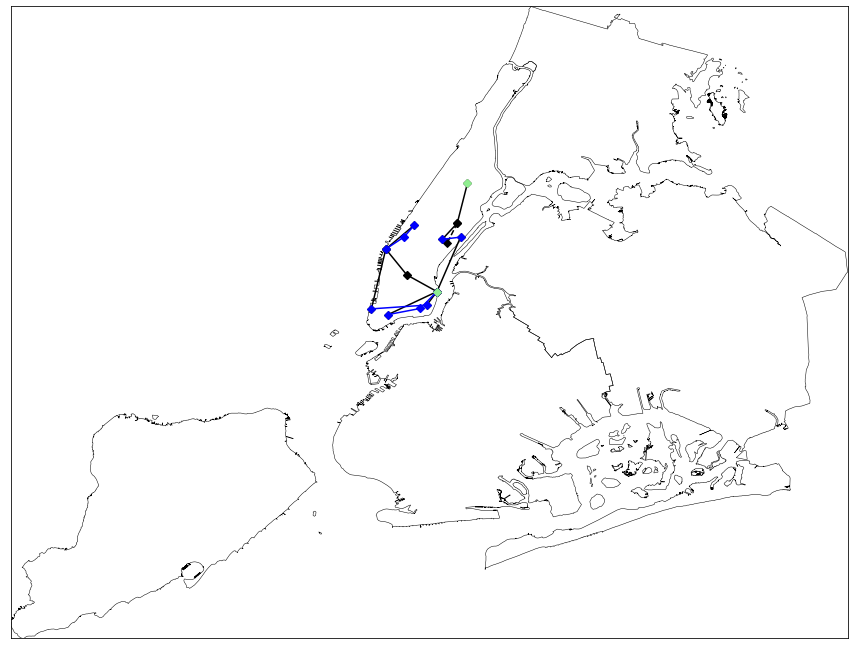

In [283]:
fixed_model = 'SBRDANew'
ambulance = 'Ambulance 1'
with open(name.format(fixed_model), 'rb') as f:
    statistics = pickle.load(f)
buildRelocationMap(loadVehicleRelocations(statistics[1][ambulance]['Record'], nodes_with_borough))

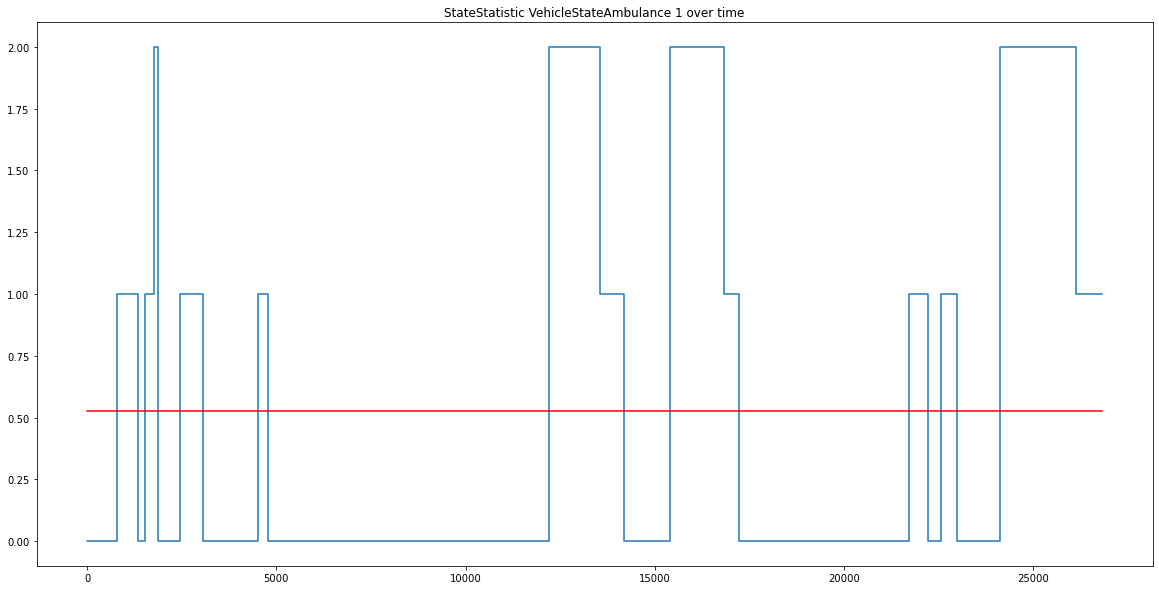

[(0, '42983020', '42983020', 'None', None),
 (0, '42426374', '42426374', 'None', None),
 (797.0, '42426374', '42430063', 'None', None),
 (1520.0, '42430063', '42442960', 'None', None),
 (1753.0, '42432847', '42427975', 'Emergency 136701', None),
 (2464.0154938244305, '42427975', '1989931095', 'None', None),
 (4514.0, '1989931095', '5174867983', 'None', None),
 (12212.0, '5174867983', '42446854', 'Emergency 136797', None),
 (13557.671241538448, '42446854', '42437699', 'None', None),
 (15400.0, '42437699', '593921859', 'Emergency 136835', None),
 (16100.025731809925, '593921859', '42440935', 'Emergency 136835', '42440935'),
 (16840.2564714161, '42440935', '42437699', 'None', None),
 (21733.0, '42437699', '42449333', 'None', None),
 (22559.0, '42449333', '1989931095', 'None', None),
 (24128.0, '1989931095', '4202931915', 'Emergency 136897', None),
 (25039.677808611203,
  '4202931915',
  '42427239',
  'Emergency 136897',
  '42427239'),
 (26152.421082908822, '42427239', '1989931095', 'None'

In [284]:
with open(name.format(fixed_model), 'rb') as f:
    statistics = pickle.load(f)
visualize(statistics[1][ambulance]['Statistics']['State'], figsize=(20,10))
statistics[1][ambulance]['Record']

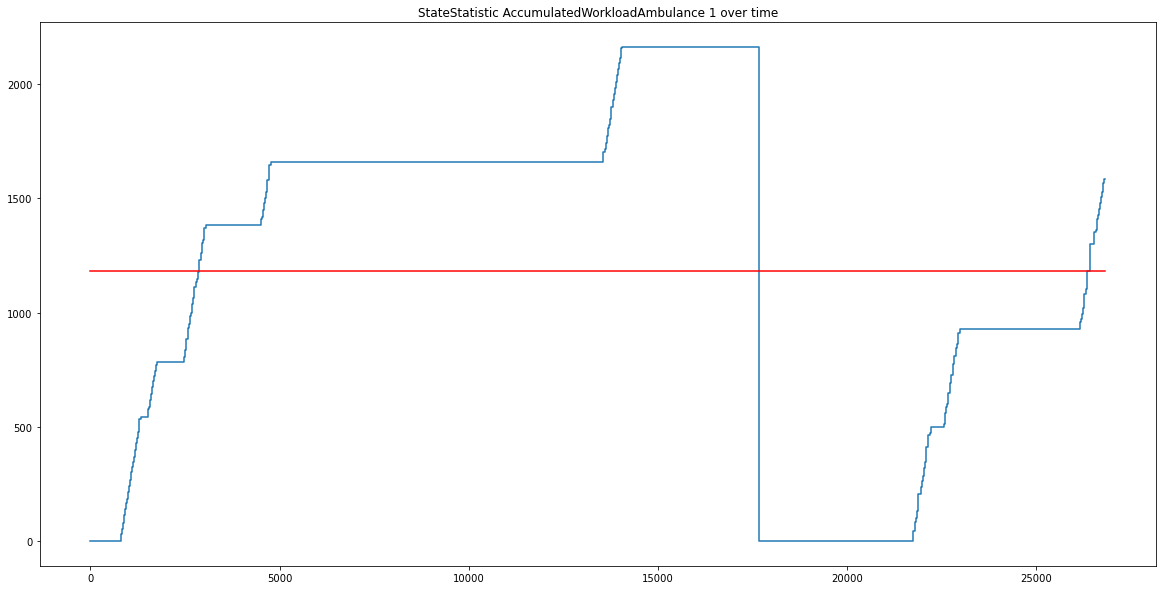

[(0, '42983020', '42983020', 'None', None),
 (0, '42426374', '42426374', 'None', None),
 (797.0, '42426374', '42430063', 'None', None),
 (1520.0, '42430063', '42442960', 'None', None),
 (1753.0, '42432847', '42427975', 'Emergency 136701', None),
 (2464.0154938244305, '42427975', '1989931095', 'None', None),
 (4514.0, '1989931095', '5174867983', 'None', None),
 (12212.0, '5174867983', '42446854', 'Emergency 136797', None),
 (13557.671241538448, '42446854', '42437699', 'None', None),
 (15400.0, '42437699', '593921859', 'Emergency 136835', None),
 (16100.025731809925, '593921859', '42440935', 'Emergency 136835', '42440935'),
 (16840.2564714161, '42440935', '42437699', 'None', None),
 (21733.0, '42437699', '42449333', 'None', None),
 (22559.0, '42449333', '1989931095', 'None', None),
 (24128.0, '1989931095', '4202931915', 'Emergency 136897', None),
 (25039.677808611203,
  '4202931915',
  '42427239',
  'Emergency 136897',
  '42427239'),
 (26152.421082908822, '42427239', '1989931095', 'None'

In [285]:
visualize(statistics[1][ambulance]['Statistics']['AccumulatedWorkload'], figsize=(20,10))
statistics[1][ambulance]['Record']
# statistics[1][ambulance]['Statistics']['State'].data

### Utiization per borough

In [275]:
model = ['SBRDANew', 'SBRDAStatic', 'ROA']
utilization = []
for m in model:
    with open(name.format(m), 'rb') as f:
        statistics = pickle.load(f)
    for v in statistics[1].keys():
        ambulance_time = statistics[1][v]['Statistics']['TimeInSystem'].data        
        borough = statistics[1][v]['Statistics']['Borough'].data
        Type = statistics[1][v]['Statistics']['Type'].data
        Shift = statistics[1][v]['Statistics']['Shift'].data
        MetersDriven = statistics[1][v]['Statistics']['MetersDriven'].data[-1][1]

        vehicle_state_1_time = 0
        vehicle_state_2_time = 0
        for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
            if d[1] == 1:
                vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
            elif d[1] == 2:
                vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
    

        relocations = 0
        for i, r in enumerate(statistics[1][v]['Record'][1:]):
            if r[1] is not None and r[2] is not None and r[3] == 'None' and statistics[1][v]['Record'][i][3] == 'None':
                relocations += 1
        
        #print(v, ambulance_time, vehicle_state_1_time, vehicle_state_2_time)
        server_utilization = [m, Shift, borough, Type, v, relocations, statistics[1][v]['Statistics']['BusyWorkload'].data[-1][1]/ambulance_time, (ambulance_time - vehicle_state_1_time - vehicle_state_2_time)/ambulance_time, vehicle_state_1_time/ambulance_time, vehicle_state_2_time/ambulance_time, MetersDriven]
        utilization.append(server_utilization)
#utilization_df = pd.DataFrame(utilization, columns = ['Model', 'Shift', 'Borough', 'Type', 'id', 'Relocations', 'Busy', 'Idle', 'Reloc', 'Att', 'MetersDriven']).sort_values(['Model','Idle'])        

In [276]:
with open('test2.pickle', 'rb') as f:
    statistics = pickle.load(f)
for v in statistics[1].keys():
    ambulance_time = statistics[1][v]['Statistics']['TimeInSystem'].data        
    borough = statistics[1][v]['Statistics']['Borough'].data
    Type = statistics[1][v]['Statistics']['Type'].data
    Shift = statistics[1][v]['Statistics']['Shift'].data
    MetersDriven = statistics[1][v]['Statistics']['MetersDriven'].data[-1][1]

    vehicle_state_1_time = 0
    vehicle_state_2_time = 0
    for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
        if d[1] == 1:
            vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
        elif d[1] == 2:
            vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]


    relocations = 0
    for i, r in enumerate(statistics[1][v]['Record'][1:]):
        if r[1] is not None and r[2] is not None and r[3] == 'None' and statistics[1][v]['Record'][i][3] == 'None':
            relocations += 1
    
    #print(v, ambulance_time, vehicle_state_1_time, vehicle_state_2_time)
    server_utilization = ['New Model', Shift, borough, Type, v, relocations, statistics[1][v]['Statistics']['BusyWorkload'].data[-1][1]/ambulance_time, (ambulance_time - vehicle_state_1_time - vehicle_state_2_time)/ambulance_time, vehicle_state_1_time/ambulance_time, vehicle_state_2_time/ambulance_time, MetersDriven]
    utilization.append(server_utilization)
utilization_df = pd.DataFrame(utilization, columns = ['Model', 'Shift', 'Borough', 'Type', 'id', 'Relocations', 'Busy', 'Idle', 'Reloc', 'Att', 'MetersDriven']).sort_values(['Model','Idle'])  

#### Plot

Text(0.5, 0.98, 'Busy fraction')

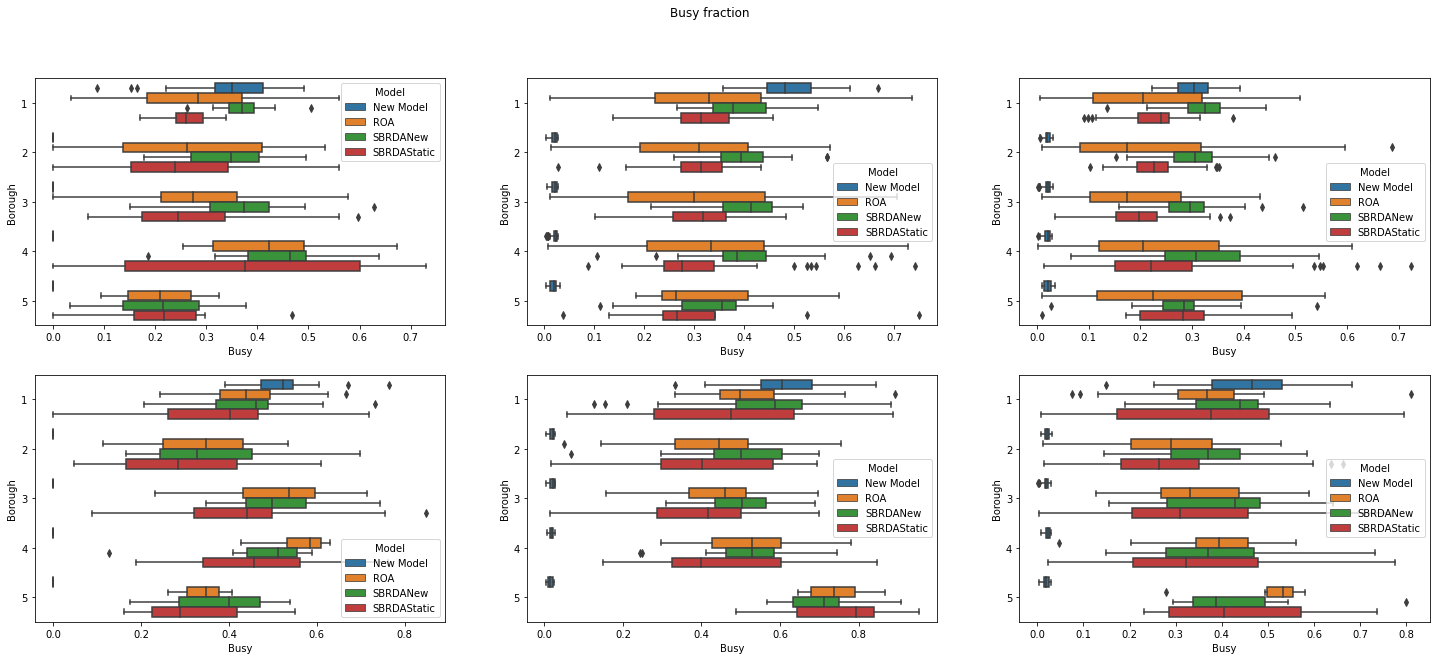

In [277]:
fig, axs = plt.subplots(2,3, figsize=(25,10))
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[0,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[0,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[0,2])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[1,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[1,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[1,2])

fig.suptitle('Busy fraction')
#plt.legend(handles=[a, b], loc="upper left")

Text(0.5, 0.98, 'Meters Driven')

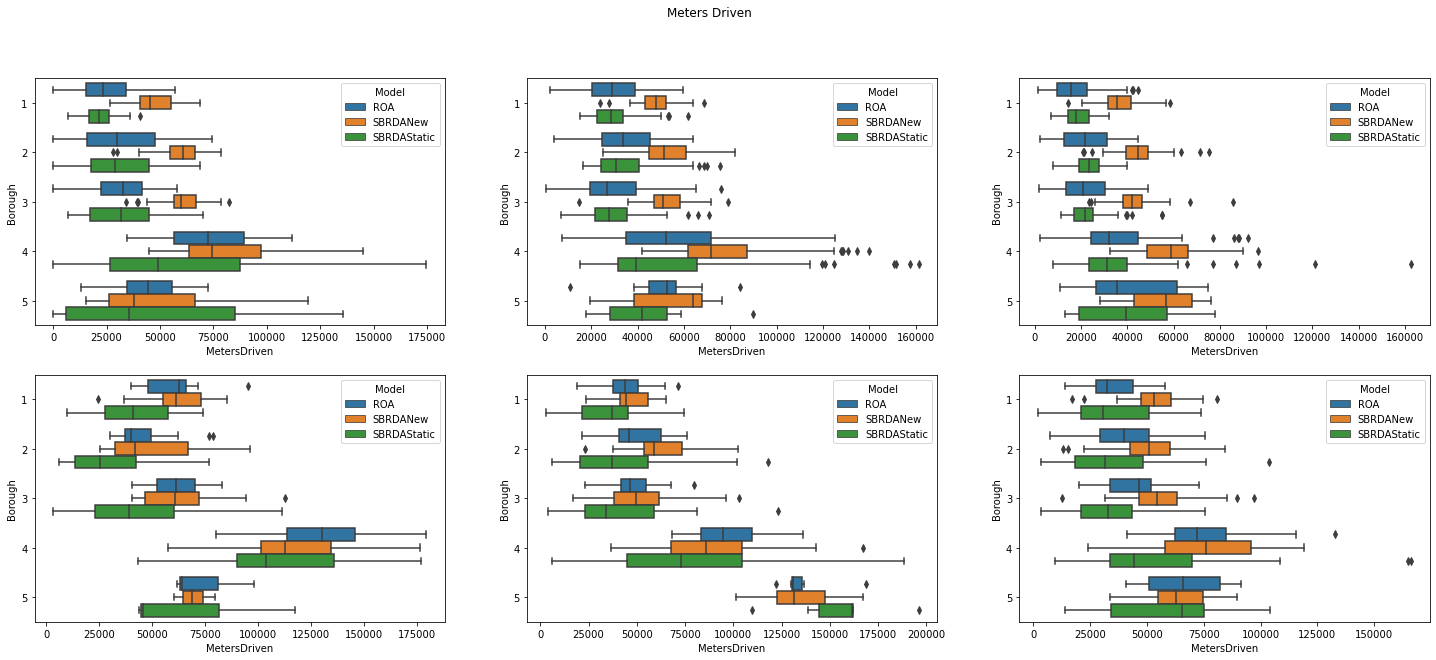

In [261]:
fig, axs = plt.subplots(2,3, figsize=(25,10))
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[0,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[0,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[0,2])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[1,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[1,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[1,2])

fig.suptitle('Meters Driven')

In [216]:
# Number of relocations
utilization_df.sort_values(['id', 'Model']).groupby(['Borough', 'Model']).sum()['Relocations']
# utilization_df.sort_values(['Model', 'Idle', 'id'])

Borough  Model      
1        ROA             394
         SBRDA          1635
         SBRDAStatic     268
2        ROA             446
         SBRDA          1617
         SBRDAStatic     283
3        ROA             625
         SBRDA          1835
         SBRDAStatic     327
4        ROA             605
         SBRDA          1071
         SBRDAStatic     225
5        ROA             156
         SBRDA           144
         SBRDAStatic      50
Name: Relocations, dtype: int64